## 14-14. 프로젝트: 한국어 데이터로 챗봇 만들기

영어로 만들었던 챗봇을 한국어 데이터로 바꿔서 훈련시켜봅시다.

시작하기 전에 우선 주요 라이브러리 버전을 확인해 봅시다.

In [1]:
import tensorflow

print(tensorflow.__version__)

2.6.0


#### Step 1. 데이터 수집하기

한국어 챗봇 데이터는 송영숙님이 공개한 챗봇 데이터를 사용합니다.

이 데이터는 아래의 링크에서 다운로드할 수 있습니다.

songys/Chatbot_data :  https://github.com/songys/Chatbot_data/blob/master/ChatbotData.csv

Cloud shell에서 아래 명령어를 입력해 주세요.

$ mkdir -p ~/aiffel/transformer_chatbot/data/

$ ln -s ~/data/* ~/aiffel/transformer_chatbot/data/

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import numpy as np
import matplotlib.pyplot as plt


In [3]:
import pandas as pd

path_to_dataset = '/aiffel/aiffel/transformer_chatbot/data/ChatbotData .csv'

data = pd.read_csv(path_to_dataset)
print(data.shape, data.head(3), data.tail(3), data.columns)

# 데이터 Nan 여부체크: Nan 없슴
print("data.isnull().sum()", data.isnull().sum())

# question, answer, label 로 분리
Question = data['Q']
Answer = data['A']
label = data['label']
print("Question",Question.shape, Question.head(10))
print("Answer",Answer.shape, Answer.head(10))
#print("label",label.shape, label.head())

(11823, 3)               Q            A  label
0        12시 땡!   하루가 또 가네요.      0
1   1지망 학교 떨어졌어    위로해 드립니다.      0
2  3박4일 놀러가고 싶다  여행은 언제나 좋죠.      0                              Q                         A  label
11820              흑기사 해주는 짝남.                    설렜겠어요.      2
11821  힘든 연애 좋은 연애라는게 무슨 차이일까?  잘 헤어질 수 있는 사이 여부인 거 같아요.      2
11822               힘들어서 결혼할까봐        도피성 결혼은 하지 않길 바라요.      2 Index(['Q', 'A', 'label'], dtype='object')
data.isnull().sum() Q        0
A        0
label    0
dtype: int64
Question (11823,) 0                     12시 땡!
1                1지망 학교 떨어졌어
2               3박4일 놀러가고 싶다
3            3박4일 정도 놀러가고 싶다
4                    PPL 심하네
5                  SD카드 망가졌어
6                    SD카드 안돼
7             SNS 맞팔 왜 안하지ㅠㅠ
8    SNS 시간낭비인 거 아는데 매일 하는 중
9          SNS 시간낭비인데 자꾸 보게됨
Name: Q, dtype: object
Answer (11823,) 0            하루가 또 가네요.
1             위로해 드립니다.
2           여행은 언제나 좋죠.
3           여행은 언제나 좋죠.
4            눈살이 찌푸려지죠.
5    다시 새로 사는

In [4]:
# 데이터정제 처리 개별 체크 셀 
[(i,x) for i,x in enumerate(Question.values) if x.find('_')!=-1]
[(i,x) for i,x in enumerate(Question.values)][7265]

(7265, '외롭지만 혼자 걸을수 있어_조성모')

#### Step 2. 데이터 전처리하기
영어 데이터와는 전혀 다른 데이터인 만큼 영어 데이터에 사용했던 전처리와 일부 동일한 전처리도 필요하겠지만 전체적으로는 다른 전처리를 수행해야 할 수도 있슴

In [5]:
# 사용할 샘플의 최대 개수
MAX_SAMPLES = len(data)    #11823  
print(MAX_SAMPLES)

11823


##### (1) 1차 전처리: 결측치 제거,  데이터 정제,  대화상 멘트가 반복될수 있어서 중복치는 유지 

In [6]:
####  1. 1차 한글 전처리 함수: dataframe형 sentence 데이터셑 전처리함수,  결측치 제거, 데이터 정제
def preprocess_sentence_df(Question, Answer) :  #, num_words=num_words):
        
    ## 결측치제거 : 1개라도 있으면, 해당행 전체 제거
    #1. Question
    print("결측치 개수",Question.isnull().sum())
    if Question.isnull().any().any():
        Question.dropna(how='any',inplace=True)
        print("결측치제거후 결측치 여부",Question.isnull().any().any())    
    #2. Answer
    print("결측치 개수",Answer.isnull().sum())
    if Answer.isnull().any().any():
        Answer.dropna(how='any',inplace=True)
        print("결측치제거후 결측치 여부",Answer.isnull().any().any())
    
    ## 데이터 정제 
    # 한글과 숫자,공백(한개이상 공백은 한개로 축소),특수문자일부 !?,.^을 제외하고 제거:[^ㄱ-힣a-zA-Z0-9!?,.^\s]
    # --> 한글형태소기를 tokenizer로 쓸 경우에는 영어및 일부선택된 특수문자외에는 모두제거(..., - - 등도 제거)
    #1. Question
    Question = Question.str.replace("[' ']+"," ")
    Question = Question.str.replace("\.{2,30}"," ") 
    Question = Question.str.replace(r"([?.!,_])", r" \1 ")
    #Question = Question.str.replace("[^ㄱ-힣0-9!?,.\^+ ^\s]","")  #한글전용형태소기인 경우 영어제외
    Question = Question.str.replace("[^ㄱ-힣a-zA-Z0-9!?,.^\s]","")  #한글영어병행형태소기인경우 영어포함                                                         
    print("한글과 공백,기타일부 등제외후 모두제거상태_Question.head()",Question.head())
    #2. Answer
    Answer = Answer.str.replace("[' ']+"," ")
    Answer = Answer.str.replace("\.{2,30}"," ") 
    Answer = Answer.str.replace(r"([?.!,^])", r" \1 ")
    #Answer = Answer.str.replace("[^ㄱ-힣0-9!?,.\^+ ^\s]","")  #한글전용형태소기인 경우 영어제외
    Answer = Answer.str.replace("[^ㄱ-힣a-zA-Z0-9!?,.^\s]","")  #한글영어병행형태소기인경우 영어포함                                                            
    print("한글과 공백,기타일부 등제외후 모두제거상태_Answer.head()", Answer.head())
    # 데이터 정제후 빈 공백만 있는 문장의 경우 제거:  Nan 입력후 행제거
    #1. Question
    Question.replace('', np.nan, inplace=True)
    print("Nan 존재유뮤",Question.isnull().any().any() )
    if Question.isnull().any().any():
        Question.dropna(how='any',inplace=True)
    #2. Answer   
    Answer.replace('', np.nan, inplace=True)
    print("Nan 존재유뮤",Answer.isnull().any().any() )
    if Answer.isnull().any().any():
        Answer.dropna(how='any',inplace=True)

    print("Question",Question.shape,Question.head())     
    print("Answer",Answer.shape,Answer.head())  
    
    return Question, Answer

In [7]:
#### 2. 1차 한글 전처리 함수: test용 개별 sentence 전처리함수, 데이터 정제
def preprocess_sentence(sentence): 
    
    ## 데이터 정제 
    # 한글과 숫자,공백(한개이상 공백은 한개로 축소),특수문자일부 !?,.^을 제외하고 제거:[^ㄱ-힣a-zA-Z0-9!?,.^\s]
    # --> 한글형태소기를 tokenizer로 쓸 경우에는 영어및 일부선택된 특수문자외에는 모두제거(..., - - 등도 제거)
    #1. sentence
    sentence = sentence.replace("[' ']+"," ")
    sentence = sentence.replace("\.{2,30}"," ") 
    sentence = sentence.replace(r"([?.!,_])", r" \1 ")
    #sentence = sentence.replace("[^ㄱ-힣0-9!?,.\^+ ^\s]","")  #한글전용형태소기인 경우 영어제외
    sentence = sentence.replace("[^ㄱ-힣a-zA-Z0-9!?,.^\s]","")  #한글영어병행형태소기인경우 영어포함                                                         
    #print("한글과 공백,기타일부 등제외후 모두제거상태_sentence",sentence)
          
    return sentence

In [8]:
# 1차 전처리: 결측치제거, 데이터 정제 처리
questions, answers = preprocess_sentence_df(Question, Answer)

결측치 개수 0
결측치 개수 0
한글과 공백,기타일부 등제외후 모두제거상태_Question.head() 0           12시 땡 ! 
1        1지망 학교 떨어졌어
2       3박4일 놀러가고 싶다
3    3박4일 정도 놀러가고 싶다
4            PPL 심하네
Name: Q, dtype: object
한글과 공백,기타일부 등제외후 모두제거상태_Answer.head() 0     하루가 또 가네요 . 
1      위로해 드립니다 . 
2    여행은 언제나 좋죠 . 
3    여행은 언제나 좋죠 . 
4     눈살이 찌푸려지죠 . 
Name: A, dtype: object
Nan 존재유뮤 False
Nan 존재유뮤 False
Question (11823,) 0           12시 땡 ! 
1        1지망 학교 떨어졌어
2       3박4일 놀러가고 싶다
3    3박4일 정도 놀러가고 싶다
4            PPL 심하네
Name: Q, dtype: object
Answer (11823,) 0     하루가 또 가네요 . 
1      위로해 드립니다 . 
2    여행은 언제나 좋죠 . 
3    여행은 언제나 좋죠 . 
4     눈살이 찌푸려지죠 . 
Name: A, dtype: object


/tmp/ipykernel_1162/834150812.py:20: FutureWarning: The default value of regex will change from True to False in a future version.
  Question = Question.str.replace("[' ']+"," ")
/tmp/ipykernel_1162/834150812.py:21: FutureWarning: The default value of regex will change from True to False in a future version.
  Question = Question.str.replace("\.{2,30}"," ")
/tmp/ipykernel_1162/834150812.py:22: FutureWarning: The default value of regex will change from True to False in a future version.
  Question = Question.str.replace(r"([?.!,_])", r" \1 ")
/tmp/ipykernel_1162/834150812.py:24: FutureWarning: The default value of regex will change from True to False in a future version.
  Question = Question.str.replace("[^ㄱ-힣a-zA-Z0-9!?,.^\s]","")  #한글영어병행형태소기인경우 영어포함
/tmp/ipykernel_1162/834150812.py:27: FutureWarning: The default value of regex will change from True to False in a future version.
  Answer = Answer.str.replace("[' ']+"," ")
/tmp/ipykernel_1162/834150812.py:28: FutureWarning: The defaul

In [9]:
print(questions.isnull().sum(), questions.head())
print(answers.isnull().sum(), answers.head())
convers = questions + answers
print("convers", convers.shape, convers.head())

0 0           12시 땡 ! 
1        1지망 학교 떨어졌어
2       3박4일 놀러가고 싶다
3    3박4일 정도 놀러가고 싶다
4            PPL 심하네
Name: Q, dtype: object
0 0     하루가 또 가네요 . 
1      위로해 드립니다 . 
2    여행은 언제나 좋죠 . 
3    여행은 언제나 좋죠 . 
4     눈살이 찌푸려지죠 . 
Name: A, dtype: object
convers (11823,) 0            12시 땡 ! 하루가 또 가네요 . 
1          1지망 학교 떨어졌어위로해 드립니다 . 
2       3박4일 놀러가고 싶다여행은 언제나 좋죠 . 
3    3박4일 정도 놀러가고 싶다여행은 언제나 좋죠 . 
4             PPL 심하네눈살이 찌푸려지죠 . 
dtype: object


1차 전처리를 통하여, 결측치는 없었고, 대화상 멘트가 반복될수 있어서,중복치는 제거하지 않았습니다.특수문자,공백,구두점처리,한글외영어등 제거흐는 데이터 정제처리후 데이터 1차 전처리 완료함

#### Step 3. SubwordTextEncoder 사용하기 : 2차 전처리로  병렬 데이터  토크나이징 실행
한국어 데이터는 형태소 분석기를 사용하여 토크나이징을 해야 한다고 많은 분이 알고 있지만, 여기서는 형태소 분석기가 아닌 이전 교재에서 사용했던 내부 단어 토크나이저인 SubwordTextEncoder를 그대로 사용해야함

TensorFlow Datasets SubwordTextEncoder 를 토크나이저로 사용해서, 단어보다 더 작은 단위인 Subword를 기준으로 토크나이징하고, 각 토큰을 고유한 정수로 인코딩, 각 문장을 토큰화하고 각 문장의 시작과 끝을 나타내는 START_TOKEN 및 END_TOKEN을 추가, 최대 길이 MAX_LENGTH 설정및 MAX_LENGTH를 넘는 문장들은 필터링, MAX_LENGTH보다 길이가 짧은 문장들은 맞도록 패딩

###### 가) 단어장(Vocabulary) 만들기

우선 각 단어에 고유한 정수 인덱스를 부여하기 위해서 단어장(Vocabulary)을 만듬,. 단어장을 만들 때는 질문과 답변 데이터셋을 모두 사용

In [10]:
import tensorflow_datasets as tfds
print("살짝 오래 걸릴 수 있어요. 스트레칭 한 번 해볼까요? 👐")

# 질문과 답변 데이터셋에 대해서 Vocabulary 생성: 
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size= 2**13)


살짝 오래 걸릴 수 있어요. 스트레칭 한 번 해볼까요? 👐


In [11]:
# tokenizer 의 크기 : target_size 8192(=2**13)개로 했는데, 8365개가 되었슴
tokenizer.vocab_size

8365

In [12]:
# 시작 토큰과 종료 토큰에 고유한 정수를 부여
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

In [13]:
print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])

START_TOKEN의 번호 : [8365]
END_TOKEN의 번호 : [8366]


In [14]:
# 시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기를 산정합니다.
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)
print(len(questions),len(answers))

8367
11823 11823


In [15]:
# subword 100 개 출력
print(tokenizer.subwords[:100])
#[(i,x) for i,x in enumerate(tokenizer.subwords) if x.find('_')!=-1]

[' . ', ' ? ', '거예요', '게_', '수_', '너무_', '는_', '더_', '거_', '좋아하는_', '이_', '을_', '도_', '잘_', ' .  ', '고_', '것_', '요', '많이_', '안_', '같아요', '좋은_', '한_', '좀_', '있어요', '가_', '은_', '나_', '에_', '있을_', '지_', '해보세요', '할_', '사람_', '면_', '건_', ' ! ', '사람이_', '마세요', '를_', '다_', '하고_', '하는_', '보세요', '해', '죠', '의_', '서_', '내가_', '싶어', '지', '내_', '네', '마음이_', '이제_', '만_', '썸_', '어떻게_', '어', '같아', '있는_', '왜_', '다른_', '세요', '나', '수도_', '시간이_', '다시_', '다', '그_', '것도_', '또_', '좋을_', '오늘_', '정말_', '싶다', '같이_', '가', '이', '네요', '될_', '해요', '자꾸_', '걸_', '없어요', '하세요', '있어', '로_', '일_', '길_', '바랄게요', '까', '돼요', '에서_', '봐요', '하면_', '할까', '으로_', '때_', '될까']


[의문] 데이터 1차전처리에서, 특수기호 5개 빼고, 다 정리했는데, tokenizer 처리후 각 토큰에 붙어있는 '_'는 무엇인가????????
영어에도 붙어 있는데???

###### 나) 각 단어를 고유한 정수로 인코딩(Integer encoding) & 패딩(Padding)
위에서 tensorflow_datasets의 SubwordTextEncoder를 사용해서 tokenizer를 정의하고 Vocabulary를 만들었다면, tokenizer.encode()로 각 단어를 정수로 변환할 수 있고 또는 tokenizer.decode()를 통해 정수 시퀀스를 단어 시퀀스로 변환할 수 있음.


In [16]:
# 임의의 22번째 샘플에 대해서 정수 인코딩 작업을 수행.
# 각 토큰을 고유한 정수로 변환
print('정수 인코딩 후의 21번째 질문 샘플: {}'.format(tokenizer.encode(questions[21])))
print('정수 인코딩 후의 21번째 답변 샘플: {}'.format(tokenizer.encode(answers[21])))

정수 인코딩 후의 21번째 질문 샘플: [5831, 605, 2501, 4176]
정수 인코딩 후의 21번째 답변 샘플: [2685, 7669, 8, 6378, 95, 1]


11823 [[8103, 1536, 3063, 37], [8158, 51, 913, 8141, 991, 1714], [8160, 1432, 4679, 8141, 3655, 76], [8160, 1432, 4679, 8141, 1292, 3655, 76], [8189, 8189, 8185, 8141, 4203]]
11823 [[3852, 72, 8082, 1], [1833, 5552, 1], [3398, 770, 129, 1], [3398, 770, 129, 1], [979, 2299, 1490, 2182, 5518, 46, 1]]
questions 길이 평균, 표준편차, 최대,최소:  5.490992133976148 2.503972833545713 21 1
answers 길이 평균, 표준편차, 최대,최소:  5.827370379768248 2.6024579131675876 29 1


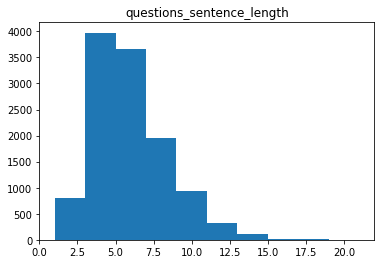

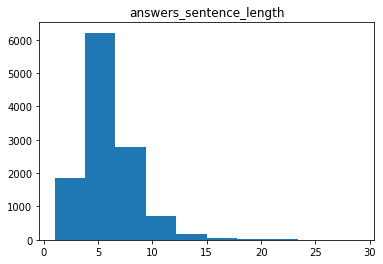

In [17]:
# sample 문장 정수 인덱스화
sample_encoding_questions = [tokenizer.encode(x) for x in questions.values] 
print(len(sample_encoding_questions), sample_encoding_questions[:5])
sample_encoding_answers = [tokenizer.encode(x) for x in answers.values] 
print(len(sample_encoding_answers),sample_encoding_answers[:5])

# max_length 설정
lenq = [len(x) for x in sample_encoding_questions]
lena = [len(x) for x in sample_encoding_answers]

# 데이터 길이 분포 파악
max_length_q = np.max(lenq)
min_length_q = np.min(lenq)
mean_length_q = np.mean(lenq)
std_length_q = np.std(lenq)
print("questions 길이 평균, 표준편차, 최대,최소: ", mean_length_q, std_length_q, max_length_q, min_length_q)

max_length_a = np.max(lena)
min_length_a = np.min(lena)
mean_length_a = np.mean(lena)
std_length_a = np.std(lena)
print("answers 길이 평균, 표준편차, 최대,최소: ", mean_length_a, std_length_a, max_length_a, min_length_a)

# 분포를 히스토그램으로 보기 plot
plt.hist(lenq)
plt.title("questions_sentence_length")
plt.show()

plt.hist(lena)
plt.title("answers_sentence_length")
plt.show()


######  max_length 설정
question, answer 공히 평균 5.5 내외, 표준편차 2.5내외, 최대길이는 각 21개, 29개인데,
max 산정에는 평균치, 표준편차, 시작토큰1개, 종료토큰1개포함하여 12개이면 충분할 것으로 판단됨


In [18]:
# 샘플의 최대 허용 길이 또는 패딩 후의 최종 길이
MAX_LENGTH = 12
print(MAX_LENGTH)

12


In [19]:
# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []
  
  for (sentence1, sentence2) in zip(inputs, outputs):
    # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

    # 최대 길이 12 이하인 경우에만 데이터셋으로 허용
    if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
      tokenized_inputs.append(sentence1)
      tokenized_outputs.append(sentence2)
  
  # 최대 길이 12 로 모든 데이터셋을 패딩
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
  
  return tokenized_inputs, tokenized_outputs


In [20]:
questions, answers = tokenize_and_filter(questions, answers)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))

단어장의 크기 : 8367
필터링 후의 질문 샘플 개수: 10740
필터링 후의 답변 샘플 개수: 10740


###### 다). 교사 강요(Teacher Forcing) 사용하기

트랜스포머 디코더에서도 교사 강요(Teacher Forcing) 를 적용.

<START_TOKEN>은 문장의 시작을 의미하는 시작 토큰, <END_TOKEN>은 문장의 끝을 의미하는 종료 토큰 <PAD>는 패딩을 위해 사용되는 패딩 토큰입니다.

입력은 <START_TOKEN>부터 시작하되, 마지막토큰을 없앰(여기서는 마지막토큰이   <END_TOKEN>이 아닌 <PAD>임
레이블은 <START_TOKEN>을 없애고 시작함

입력 : <START_TOKEN> I AM A STUDENT <END_TOKEN> <PAD> <PAD> <PAD> 

레이블 : I AM A STUDENT <END_TOKEN> <PAD> <PAD> <PAD> <PAD>

질문과 답변의 쌍을 tf.data.Dataset API의 입력으로 사용하여 파이프라인을 구성,이때, 교사 강요를 위해서 answers[:, :-1]를 디코더의 입력값, answers[:, 1:]를 디코더의 레이블로 사용
  
    
[참고] 아래 코드중 dataset.prefetch(tf.data.experimental.AUTOTUNE)에대한 설명     
  
훈련 속도를 더 빠르게
    
prefetch(1)을 호출하면 데이터셋은 항상 한 배치가 미리 준비되도록 최선을 (=알고리즘이 한 배치로 작업하는 동안 이 데이터셋이 동시에 다음 배치를 준비)
    
GPU에서 훈련하는 스텝을 수행하는 것보다 짧은 시간안에 한 배치 데이터를 준비할 수 있다. (=GPU 100%활용하는 방법)
    
interleave메소드와 map에 num_parallel_calls을 함께 사용하면 데이터를 적재하고 전처리할때 CPU의 멀티코어를 사용해 더 빠르게 준비 가능
    
prefetch는 일반적으로 하나도 충분, tf.data.experimental.AUTOTUNE을 전달하면 텐서플로가 자동으로 결정 (하지만 아직 실험 단계)
    
GPU에서 데이터를 바로 프리페치할 수 있는 tf.data.experimental.prefetch_to_device()를 확인해보자   

In [41]:
BATCH_SIZE = 64
BUFFER_SIZE = 12000

# 디코더는 이전의 target을 다음의 input으로 사용
# 이에 따라 outputs에서는 START_TOKEN을 제거.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)  
# dataset.prefetch: 데이터 batch를 미리 가져와서,대기시켜 처리속도 빠르게 하는 기능


#### Step 4. 모델 구성하기
위 실습 내용을 참고하여 트랜스포머 모델을 구현합니다.

##### 포지셔널 인코딩 레이어

In [23]:
# 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):

  def __init__(self, position, d_model):   # position: 입력문장의 최대길이, d_model : 차원수
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)
    #self.my_transpose = my_transpose
    
  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    #print("angles",angles.shape, angles)
    return position * angles

  def positional_encoding(self, position, d_model):
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)
    #print("angle_rads",angle_rads.shape,angle_rads)
    
    # 배열의 짝수 인덱스에는 sin 함수 적용
    sines = tf.math.sin(angle_rads[:, 0::2])
    #print("sines",sines.shape, sines)
    
    # 배열의 홀수 인덱스에는 cosine 함수 적용
    cosines = tf.math.cos(angle_rads[:, 1::2])
    #print("cosines",cosines.shape, cosines)
    
    # sin과 cosine이 교차되도록 재배열
    pos_encoding = tf.stack([sines, cosines], axis=0)
    #print("pos_encoding1",pos_encoding.shape, pos_encoding)
    pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) # 원래축순서(0,1,2)==> Transpose된 축순서(1,2,0)
    #print("pos_encoding2",pos_encoding.shape, pos_encoding)
    pos_encoding = tf.reshape(pos_encoding, [position, d_model])
    #print("pos_encoding3",pos_encoding.shape, pos_encoding)
    pos_encoding = pos_encoding[tf.newaxis, ...]
    #print("pos_encoding4",pos_encoding.shape, pos_encoding)
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    posinput = inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]
    #print("posinput",posinput ) 
    return posinput     # inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]


##### 스케일드 닷 프로덕트 어텐션 함수 :   패딩에 마스크 추가  

In [24]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
  # 어텐션 가중치는 Q와 K의 닷 프로덕트
  matmul_qk = tf.matmul(query, key, transpose_b=True) #tf.matmul(a,b,transpose_a=False,transpose_b=False)

  # 가중치를 정규화
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # 패딩에 마스크 추가  ?????
  if mask is not None:
    logits += (mask * -1e9)

  # softmax적용
  attention_weights = tf.nn.softmax(logits, axis=-1)

  # 최종 어텐션은 가중치와 V의 닷 프로덕트
  output = tf.matmul(attention_weights, value)
  return output


##### MultiHeadAttention 함수

In [25]:
# MultiHeadAttention 함수
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)

  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # Q, K, V에 각각 Dense를 적용합니다
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # 병렬 연산을 위한 머리를 여러 개 만듭니다
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # 스케일드 닷 프로덕트 어텐션 함수
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # 최종 결과에도 Dense를 한 번 더 적용합니다
    outputs = self.dense(concat_attention)

    return outputs


##### 패딩 마스킹

In [26]:
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, sequence length)
  return mask[:, tf.newaxis, tf.newaxis, :]

In [27]:
print(create_padding_mask(tf.constant([[1, 2, 0, 3, 0], [0, 0, 0, 4, 5]])))

tf.Tensor(
[[[[0. 0. 1. 0. 1.]]]


 [[[1. 1. 1. 0. 0.]]]], shape=(2, 1, 1, 5), dtype=float32)


##### look ahead 마스킹

In [28]:
def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)  
  # lower -1시 tf.linalg.band_part에서 아래쪽이 1로채워진 하삼각행렬아닌가? 아래 예를 보면
  # 상삼각으로 위에가 1로 되었슴, 그러면 위의 1이 마스킹된다는 의미이지?
  padding_mask = create_padding_mask(x)
  return tf.maximum(look_ahead_mask, padding_mask)

In [29]:
print(create_look_ahead_mask(tf.constant([[1, 2, 3, 4, 5]])))

tf.Tensor(
[[[[0. 1. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 0. 1. 1.]
   [0. 0. 0. 0. 1.]
   [0. 0. 0. 0. 0.]]]], shape=(1, 1, 5, 5), dtype=float32)


##### (1) 인코더 레이어 함수

In [30]:
# 인코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재합니다.
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })

  # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  # 두 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)


#####  (2) 인코더 모델 생성 함수

In [31]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # num_layers만큼 쌓아올린 인코더의 층.
  for i in range(num_layers):
    outputs = encoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)


##### (3) 디코더 레이어 함수

In [32]:
# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })

  # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

  # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
  attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
      })

  # 마스크드 멀티 헤드 어텐션의 결과는
  # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

  # 세 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

##### (4) 디코더 모델 생성함수

In [33]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')

  # 패딩 마스크
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  
  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  # Dropout이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)


##### (5) 트랜스포머 모델 생성함수

In [57]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  # 인코더에서 패딩을 위한 마스크
  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

  # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
  # 내부적으로 패딩 마스크도 포함되어져 있습니다.
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)

  # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
  # 디코더에서 패딩을 위한 마스크
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  # 인코더
  enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[inputs, enc_padding_mask])

  # 디코더
  dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  # 완전연결층
  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)


##### (6) 트랜스포머 모델 생성

In [89]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 512 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.2 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 512)    7439872     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

#### (7) 트랜스포머 모델 손실 함수(Loss function)
레이블인 시퀀스에 패딩이 되어 있으므로, loss를 계산할 때 패딩 마스크를 적용해야 함

In [81]:
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)


##### (8) 트랜스포머 모델에 쓰일 커스텀 된 학습률(Learning rate) 함수
딥러닝 모델학습 시 learning rate는 매우 중요한 하이퍼파라미터임, 최근에는 모델학습 초기에 learning rate를 급격히 높였다가, 이후 train step이 진행됨에 따라 서서히 낮추어 가면서 안정적으로 수렴하게 하는 고급 기법을 널리 사용, 이런 방법을 커스텀 학습률 스케줄링(Custom Learning rate Scheduling)이라함

In [90]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)


##### (9) 트랜스포머 모델 컴파일
손실 함수와 커스텀 된 학습률(learning rate)을 사용하여 모델을 컴파일

In [91]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])


##### (10) 트랜스포머 모델 훈련
학습을 진행

In [92]:
EPOCHS = 50
history = model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/50
168/168 [==============================] - 12s 43ms/step - loss: 4.5492 - accuracy: 0.1053
Epoch 2/50
168/168 [==============================] - 7s 43ms/step - loss: 3.5514 - accuracy: 0.1753
Epoch 3/50
168/168 [==============================] - 7s 43ms/step - loss: 3.2001 - accuracy: 0.1797
Epoch 4/50
168/168 [==============================] - 7s 42ms/step - loss: 3.0207 - accuracy: 0.1900
Epoch 5/50
168/168 [==============================] - 7s 42ms/step - loss: 2.8516 - accuracy: 0.1990
Epoch 6/50
168/168 [==============================] - 7s 42ms/step - loss: 2.6696 - accuracy: 0.2115
Epoch 7/50
168/168 [==============================] - 7s 41ms/step - loss: 2.4655 - accuracy: 0.2282
Epoch 8/50
168/168 [==============================] - 7s 42ms/step - loss: 2.2422 - accuracy: 0.2512
Epoch 9/50
168/168 [==============================] - 7s 42ms/step - loss: 1.9990 - accuracy: 0.2789
Epoch 10/50
168/168 [==============================] - 7s 42ms/step - loss: 1.7431 - accur

history.history.keys() dict_keys(['loss', 'accuracy'])


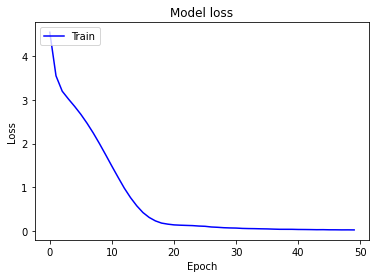

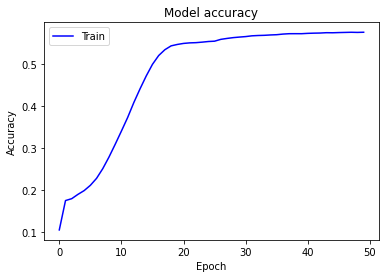

"\n# 학습율 변화 시각화\nplt.plot(lrHistory.lr,'red')\nplt.title('Model learning rate')\nplt.xlabel('Epoch')\nplt.ylabel('LearningRate')\nplt.legend(['Train'], loc='upper left')\nplt.show()\n"

In [93]:
print("history.history.keys()", history.history.keys())
    
# 훈련 과정 시각화 (loss): train
plt.plot(history.history['loss'],'blue')
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train'], loc='upper left')
plt.show()       

# 훈련 과정 시각화 (accuracy): train
plt.plot(history.history['accuracy'],'blue')
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train'], loc='upper left')
plt.show()


#### Step 5. 모델 평가하기
Step 1에서 선택한 전처리 방법을 고려하여 입력된 문장에 대해서 대답을 얻는 예측 함수를 만듬.

예측(inference) 단계는 기본적으로 다음과 같은 과정을 거칩니다.

새로운 입력 문장에 대해서는 훈련 때와 동일한 전처리를 거친다.

입력 문장을 토크나이징하고, START_TOKEN과 END_TOKEN을 추가한다.

패딩 마스킹과 룩 어헤드 마스킹을 계산한다.

디코더는 입력 시퀀스로부터 다음 단어를 예측한다.

디코더는 예측된 다음 단어를 기존의 입력 시퀀스에 추가하여 새로운 입력으로 사용한다.

END_TOKEN이 예측되거나 문장의 최대 길이에 도달하면 디코더는 동작을 멈춘다.

위의 과정을 모두 담은 decoder_inference() 함수를 만듭니다.

In [74]:
#  decoder_inference() 함수
def decoder_inference(sentence):
  sentence = preprocess_sentence(sentence)  
  # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
  # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
  # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
  output_sequence = tf.expand_dims(START_TOKEN, 0)

  # 디코더의 인퍼런스 단계
  for i in range(MAX_LENGTH):
    # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
    predictions = model(inputs=[sentence, output_sequence], training=False)
    predictions = predictions[:, -1:, :]

    # 현재 예측한 단어의 정수
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
    # 이 output_sequence는 다시 디코더의 입력이 됩니다.
    output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

  return tf.squeeze(output_sequence, axis=0)


임의의 입력 문장에 대해서 decoder_inference() 함수를 호출하여 챗봇의 대답을 얻는 sentence_generation() 함수

In [75]:
def sentence_generation(sentence):
  # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
  prediction = decoder_inference(sentence)

  # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  print('입력 : {}'.format(sentence))
  print('출력 : {}'.format(predicted_sentence))

  return predicted_sentence


#### 7가지 질문또는 멘트에 대한 모델의 응답:  5개는 일상생활관련, 2개는 주식및 정치관련 대화내용임

In [102]:
sentence_generation('날씨가 춥지요 ?')

입력 : 날씨가 춥지요 ?
출력 : 감기 조심하세요 . 


'감기 조심하세요 . '

In [107]:
sentence_generation("요즘 주식시장 불투명하네요")

입력 : 요즘 주식시장 불투명하네요
출력 : 많이 힘들었을 거라 생각해요 . 


'많이 힘들었을 거라 생각해요 . '

In [110]:
sentence_generation("너는 누구니")

입력 : 너는 누구니
출력 : 저는 위로해드리는 로봇이에요 . 


'저는 위로해드리는 로봇이에요 . '

In [116]:
sentence_generation("공부 골아프지만 재미있네요")

입력 : 공부 골아프지만 재미있네요
출력 : 미래의 배우자가 달라져요 . 


'미래의 배우자가 달라져요 . '

In [115]:
sentence_generation("즐거운 하루되세요")

입력 : 즐거운 하루되세요
출력 : 내일은 만날 수 있을 거예요 . 


'내일은 만날 수 있을 거예요 . '

In [117]:
sentence_generation("우리나라 정치문화 개선해야지요?")

입력 : 우리나라 정치문화 개선해야지요?
출력 : 하나씩 의 취향 차이입니다 . 


'하나씩 의 취향 차이입니다 . '

In [118]:
sentence_generation("인재에게는 책임감이 필요하지요")

입력 : 인재에게는 책임감이 필요하지요
출력 : 그럴거예요 . 


'그럴거예요 . '

#### [질문에 대한 모델의 응답의 적절성 수준 평가]
일상생활멘트및 질문과 주식시장, 정치측면 질문및 멘트를 섞어서 7개를 했는데, 정치측면 질문은 전혀 엉뚱하지는 않지만, 어울리지 않는
응답이 나왔으나, 나머지 6개는 그럴듯하다는 생각이 들수 있는 응답을 했다는 평가를 할수 있겠습니다.

Epoch 50정도인데, 이전 프로젝트에서의 seq2seq 모델의 결과보다 조금은 더 그럴듯하다는 생각이 듭니다만, GPT3를 만든 트랜스포머의 잠재능력이 발휘되도록 데이터가 충분했으면 평가가 훨씬 더좋았겠다 생각을 해봤습니다.


## 회고 

본 프로젝트는 트랜스포머의 작업처리과정과 내부구조를 익히며, 한글 corpus를 사용하여,트랜스포머 챗봇을 만들어서, 성능을 평가해보는 프로젝트입니다.

#### Step 1. 데이터 수집하기

한국어 챗봇 데이터는 송영숙님이 공개한 챗봇 데이터를 사용하는데, 사랑과 이별, 일상의 대화가 Question, Answer형태로 짝을 이룬 
11823개의 문장 pair로 되어있습니다.(라벨도 있는데 제외) 

데이터의 내용을 눈으로 처음부터 끝까지 대략 살펴보면,Question, Answer 데이터가 일상생활의 대화이고 1만여개가 조금 넘는 적은 데이터라서, 일상생활에 관한 대화를 할수 있는 챗봇으로서, 그외 뉴스, 철학적이나, 전문적인 내용을 대화할수 있는 종합형 챗봇이 될수는 없을 것 같았습니다.  

#### Step 2. 데이터 전처리하기

먼저, 전처리 함수를 만들었는데, csv dataframe형태로 로드한 11823개의 문장을 일괄 전처리하는 preprocess_sentence_df(Question, Answer)함수와,  문장 하나씩을 전처리하면서,모델학습후 추론하는데 쓸수있는 preprocess_sentenc(sentence)함수를 만들었습니다.
preprocess_sentence_df(Question, Answer)를 통해서, 불필요한 특수문자,공백,구두점처리, 토크나이저가 한글형태소분석기가 아닌데다, 영어가 섞인 문장들이 더러 있어서, 한글과 영어를 포함해서 데이터 정제를 했으며,,결측치는 없었고, 중복문장은 제거하지 않았는데 이는 대화형 문장이므로,멘트가 반복될수 있어서였습니다. 
이렇게 해서 데이터 1차 전처리를 깔끔하게 완료하였습니다.

#### Step 3. SubwordTextEncoder 사용하기 : 2차 전처리로  병렬 데이터  토크나이징 실행
한국어 데이터는 형태소 분석기를 사용하여 토크나이징을 해야 한다고 생각했는데, 여기서는 프로젝트 가이드에서 추천하고,전 교재에서 사용했던 내부 단어 토크나이저인 SubwordTextEncoder를 그대로 사용했습니다.
TensorFlow Datasets SubwordTextEncoder 를 토크나이저로 사용해서, 단어보다 더 작은 단위인 Subword를 기준으로 토크나이징하고, 각 토큰을 고유한 정수로 인코딩, 각 문장을 토큰화하고 각 문장의 시작과 끝을 나타내는 START_TOKEN 및 END_TOKEN을 추가, 최대 길이 MAX_LENGTH 설정및 MAX_LENGTH를 넘는 문장들은 필터링, MAX_LENGTH보다 길이가 짧은 문장들은 MAX_LENGTH에 맞도록 패딩했습니다.

###### 가) 단어장(Vocabulary) 만들기

각 단어에 고유한 정수 인덱스를 부여하기 위해서 단어장을 만들었는데, 질문과 답변 데이터셋을 모두 사용했으며,
시작 토큰과 종료 토큰에 고유한 정수를 부여했습니다.
tokenizing 결과를 보면, tokenizer 의 크기(target_size)를 8192(= 2 ** 13)개로 했는데, tokenizer.vocab_size는 그것보다 많은 8365개가 되었으며, START_TOKEN 8365번, END_TOKEN 8366번의 정수인덱스를 부여했습니다.

###### 나) 각 단어를 고유한 정수로 인코딩(Integer encoding) 
위에서 tensorflow_datasets의 SubwordTextEncoder를 사용해서 Vocabulary를 만들고서,tokenizer.encode()로 각 단어를 정수인덱스로 변환하거나,tokenizer.decode()를 통해 정수인덱스 문장을 단어인덱스 문장으로 변환할 수 있게 되었습니다.

######  max_length 설정 & 패딩(Padding)
question, answer 데이터의 분포를 살펴보면, 둘다 공히 평균 5.5 내외, 표준편차 2.5 내외, 최대길이는 각 21개, 29개인데, 히스토그램을 보니, max 산정에는 평균치, 표준편차, 시작토큰1개, 종료토큰1개포함하여 12개이면 충분할 것으로 판단되어
MAX_LENGTH는 12로 설정했습니다. 

그리고서, tokenize_and_filter(inputs, outputs)함수를 만들어서, 전체 정수 인코딩, MAX_LENGTH 12 를 초과하는 샘플 제거,tf.keras.preprocessing.sequence.pad_sequences을 이용한 'post'방식의 패딩처리를 하였습니다.

###### 다). 교사 강요(Teacher Forcing) 사용하기

seq2seq에서와 마찬가지로 트랜스포머 디코더에서도 교사 강요(Teacher Forcing) 를 적용하였는데,.
decoder input data 은 <START_TOKEN>부터 시작하되, 마지막토큰을 없앴고,decoder target data 는 <START_TOKEN>을 없애고 시작했습니다

question, answer의 pair를 tf.data.Dataset API의 입력으로 사용하여 파이프라인을 구성하고 교사 강요를 위해서 answers[:, :-1]를 decoder input data 로, answers[:, 1:]를 decoder target data로 사용했습니다.
    
이때, 데이터 파이프 라인내에 BATCH_SIZE = 64, BUFFER_SIZE = 12000 로 설정했고, 데이터 batch를 미리 가져와서,대기시켜 처리속도 빠르게 하는 dataset.prefetch(tf.data.experimental.AUTOTUNE) 기능을 처음 사용해 보았습니다. 


#### Step 4. 모델 구성하기
    
먼자,모델구성에 필요한 함수로 실습시간에 배운 포지셔널 인코딩 레이어 함수, 스케일드 닷 프로덕트 어텐션 함수,    
MultiHeadAttention 함수, 패딩 마스킹,look ahead 마스킹함수를 생성하고서,
다음의 순서로 모델을 구성하였습니다.

포지셔널 인코딩 레이어 함수에서, 사인,코사인 곡선이 -1~1 사이로 주기성있게 교차와 시차를 반복적 파동하며 서로 다르게 움직이긴 하는데, 궤적상 포지셔널인덱싱 위치를 지정하는데,사인곡선과 코사인 곡선이 주기적으로  교차되는 곳에서는 position이 동일해져서, 타임스텝상 문제가 생기지 않을까 의문이 생겨서, model dimention을 10000개까지 늘려서, 동일해지지 않는지 리스트 컴프리헨션내에서 두쌍을  대비시켜 보았는데, x축이positional 인덱스인 정수에서는 교차하지 않고, positional 인덱스인 정수 사이의 소수점에서만 동일해져서, 전혀 상관없았습니다. 

(1) 인코더 레이어 함수 만들었고,   

(2) 인코더 모델 생성 함수만들었고,

(3) 디코더 레이어 함수만들었고,

(4) 디코더 모델 생성함수만들었고,   

(5) 트랜스포머 모델 생성함수만들었고,    

(6) 트랜스포머 모델 생성:  하이퍼파라미터는 

NUM_LAYERS = 2, 
D_MODEL = 512, 
NUM_HEADS = 8, 
UNITS = 512, 
DROPOUT = 0.2 
로 설정
    
(7) 트랜스포머 모델 손실 함수(Loss function)만들었고,

(8) 트랜스포머 모델에 쓰일 커스텀 된 학습률(Learning rate) 함수:

모델학습 초기에 learning rate를 급격히 높였다가, 이후 train step이 진행됨에 따라 서서히 낮추어 가면서 안정적으로 수렴하게 하는 커스텀 학습률 스케줄링(Custom Learning rate Scheduling) 사용   
    
(9) 트랜스포머 모델 컴파일: 손실 함수와 커스텀 된 학습률(learning rate)을 사용하여 모델을 컴파일    
    
(10) 트랜스포머 모델 훈련: Epoch 50으로 학습을 진행했으며, history에 학습과정의 loss, accuracy 기록했습니다.
     여러번의 Epoch 변경끝에 Epoch 50로 결정하고,학습결과로는  loss 0.0239, accuracy: 0.5761 이었습니다. 
     Epoch 50으로 한 이유는 valid data가 없어서, 과적합을 파악하기 곤란해서,Epoch를 얼마나 길게 해야할지 파악이 않되는 점이 
     좀 아쉬웠습니다. 
    
(11) 훈련 과정 시각화: 학습loss,  학습 accuracy 를 Epoch 진행에따라 궤적을 보았는데, Epoch 20넘어가면서 부터 수렴되었습니다.     
    
#### Step 5. 모델 평가하기
Step 1에서 선택한 한문장단위 전처리함수를 사용하여, 입력된 문장에 대해서 대답을 얻는 decoder_inference() 함수를 만들었습니다.

decoder_inference() 함수내에는 새로운 입력 문장에 대해서는 훈련 때와 동일한 전처리를 거치고, 입력 문장을 토크나이징하고,
START_TOKEN과 END_TOKEN을 추가하고서, 패딩 마스킹과 룩 어헤드 마스킹을 하며, 
디코더는 디코더 입력 시퀀스로부터 다음 타임스텝의 단어를 예측하며, 예측된 다음 단어를 기존의 입력 시퀀스에 추가하여,
새로운 입력으로 사용하는 과정을 코딩했습니다. 그 과정을 반복하다가, END_TOKEN이 예측되거나 문장의 최대 길이에 도달하면,
디코더는 동작을 멈추고, 예측을 종료하게끔 코딩을 했습니다.

임의의 입력 문장에 대해서 decoder_inference() 함수를 호출하여 챗봇의 대답을 얻는 sentence_generation() 함수를 만들었고,
이 함수를 통하여, Question input sentence에대해, 얼마나 그럴듯하고, 납득이 가는 Answer output sentence를 내는지
평가를 하였습니다.

#### [질문에 대한 모델의 응답의 적절성 수준 평가]
일상생활멘트및 질문과 주식시장, 정치측면 질문및 멘트를 섞어서 7개를 했는데, 정치측면 질문은 전혀 엉뚱하지는 않지만, 어울리지 않는
응답이 나왔으나, 나머지 6개는 맥락에 그럴듯하게 맞다는 생각이 들수 있는 응답을 했다는 평가를 할수 있겠습니다.

Epoch 50정도인데, 이전 프로젝트에서의 seq2seq 모델의 결과보다 조금 더 맥락상 그럴듯하다는 생각이 듭니다만, GPT3를 만든 트랜스포머의 잠재능력이 발휘되도록 데이터가 충분했으면 맥락상 평가가 훨씬 더좋았겠다는 생각을 해봤습니다.
 
그리고, 초거대 Ai챗봇인 GPT3를 만들만큼 Capacity가 큰 모델이라 일상생활 대화 11000여개문장은 작아서, 충분히 평가받지 못한다는 생각이 일견 들었으나, 그러한 트랜스포머를 이렇게 프로젝트를 통해서 익힐수 있어서 아주 좋은 학습이었고, 이번 프로젝트에서 익힌 트랜스포머의 지식을 토대로 심화학습단계에서, 더 깊게 더 크게 모델을 확장해서, 더 충분한 데이터로 트랜스포머 모델의 능력을 확인해 보고 싶습니다. 

## 루브릭

아래의 기준을 바탕으로 프로젝트를 평가합니다.

평가문항	상세기준

#### 1. 한국어 전처리를 통해 학습 데이터셋을 구축하였다.

공백과 특수문자 처리, 토크나이징, 병렬데이터 구축의 과정이 적절히 진행되었다.

#### 2. 트랜스포머 모델을 구현하여 한국어 챗봇 모델 학습을 정상적으로 진행하였다.

구현한 트랜스포머 모델이 한국어 병렬 데이터 학습 시 안정적으로 수렴하였다.

#### 3. 한국어 입력문장에 대해 한국어로 답변하는 함수를 구현하였다.

한국어 입력문장에 맥락에 맞는 한국어로 답변을 리턴하였다.